In [1]:
from mpl_rcParams import * 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.integrate import complex_ode, odeint

cmap = cm.plasma_r

from scaling_lib.mode_solver import solve_modes
from scaling_lib.deltaN import *
from scaling_lib.simulation_tdwg_repo import WaveguideSimulationWithBackground
from scaling_lib.misc_helpers import E2a, a2atilde
import scaling_lib.ftutils_np as ftutils

## Solve for waveguide modes

In [2]:
λ0 = 1.55 #um
ncore = 1.8
nclad = 1.7 
dn_val = ncore-nclad

d_singlemode = λ0/2/np.sqrt(ncore**2-nclad**2)
k0 = 2*np.pi/λ0

Nmodes = 3
d_wg = 1.5*Nmodes 

In [3]:
Lx = 3.5*d_wg
Nx = 2**7 

dx = Lx/(Nx-1) # stepsize in transverse dimension
x_axis = ftutils.ft_t_axis(Nx, dx)

# x_axis = np.linspace(-Lx/2, Lx/2, Nx)
x2ind = lambda x: np.argmin(np.abs(x_axis-x))

In [4]:
dn_wg_slice = np.zeros(Nx)
dn_wg_slice[x2ind(-d_wg/2):x2ind(d_wg/2)] = dn_val

In [5]:
betas, Evecs = solve_modes(x_axis, nclad, k0, dn_wg_slice, Nmodes)

In [6]:
fig_height = 1

## Now simulate some coupling between the modes

In [7]:
dz = 0.2
Lz = 1e3 
N_com = 10

Nz = int(np.round((Lz/dz)))
z_axis = (np.arange(Nz)+1)*dz

In [8]:
U = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]).T 
A = logm(U)/(1j*k0*Lz)

In [9]:
dn_prog = make_deltaN(A, Evecs, betas, x_axis, z_axis)

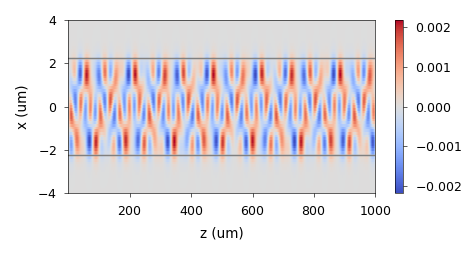

In [10]:
plt.subplots(figsize=(3.3, 1.5))
img = plt.pcolormesh(z_axis, x_axis, dn_prog.real.T, cmap="coolwarm")
plt.axhline(d_wg/2,  color="gray", linestyle="-")
plt.axhline(-d_wg/2, color="gray", linestyle="-")
plt.xlabel("z (um)")
plt.ylabel("x (um)")
plt.ylim(-4, 4)
plt.colorbar()

## Run simulator

In [11]:
device = "cpu"
wg = WaveguideSimulationWithBackground(nclad, x_axis, z_axis, Ncom=1)

x = torch.eye(Nmodes, dtype=torch.complex64).to(device)
input_modes = torch.from_numpy(Evecs).to(device, dtype=torch.complex64)
input_beams = x@input_modes

wg.set_background_delta_n(torch.from_numpy(dn_wg_slice))
wg.run_simulation_slow(input_beams,  dn_prog);

Emat_x = wg.Emat_x
z_list = wg.z_list

Text(0.5, 1.02, 'Real(E(x, z))')

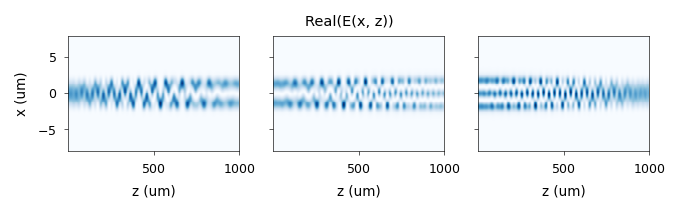

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(5, fig_height), sharey=True)

for i in range(Nmodes):
    plt.sca(axs[i])
    Ex_i = Emat_x[:, i, :]
    img = plt.pcolormesh(z_list, x_axis, (torch.abs(Ex_i).T)**2, cmap="Blues")
    plt.xlabel("z (um)")

plt.sca(axs[0])
plt.ylabel("x (um)")
plt.suptitle("Real(E(x, z))", y=1.02, fontsize=7)

## Plot mode amplitudes

In [13]:
a_list = E2a(Emat_x[:, 0, :].to(torch.cfloat), Evecs, x_axis)
atilde_list = a2atilde(a_list, (betas - nclad*k0), z_list.numpy())

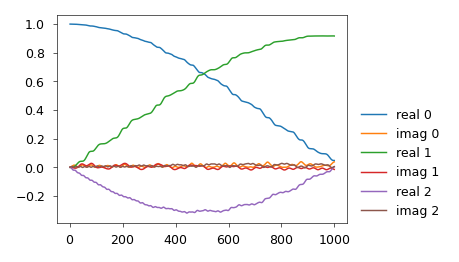

In [14]:
for i in range(Nmodes):
    plt.plot(z_list, np.real(atilde_list[i]), label=f"real {i}")
    plt.plot(z_list, np.imag(atilde_list[i]), label=f"imag {i}")
plt.legend(loc = (1.03, 0.0))
# plt.grid()

# Compare to coupled-mode theory with rotating-wave approximation

In [15]:
def da_rot(z, x):
    return 1j*k0*A@x

r = complex_ode(da_rot)
x0 = 0j*np.zeros(Nmodes)
x0[0] = 1.0+0j
# x0[2] = 1.0+0j
r.set_initial_value(x0, 0.0)

output_rot = []

for i in range(Nz):
    output_rot.append(r.integrate(r.t+dz))

output_rot = np.array(output_rot).T

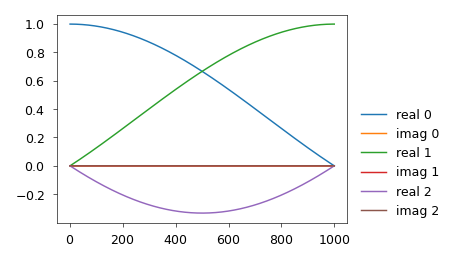

In [16]:
for i in range(Nmodes):
    plt.plot(z_axis, np.real(output_rot[i]), label=f"real {i}")
    plt.plot(z_axis, np.imag(output_rot[i]), label=f"imag {i}")
plt.legend(loc = (1.03, 0.0))
# plt.grid()